# Pix2Pix 실습

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from math import log10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # tensor.to(device) 방식을 통해서 cpu -> gpu로 보낼 수 있습니다.

## Facades Dataloader

![image.png](attachment:image.png)

In [0]:
# Image를 Load하기 위한 함수입니다.
def load_img(filepath):
    img = Image.open(filepath).convert('RGB') # Image File을 Load합니다.
    img = img.resize((256, 256), Image.BICUBIC) # Image의 크기를 256x256으로 바꿔줍니다.
    return img


"""
MNIST 또는 CIFAR-10과 같이 torchvision 라이브러리에서 제공하지 않는 Dataset의 경우에는 직접 data.Dataset을 상속받아서 만들어야합니다.
이 때, __init__, __getitem__, __len__은 항상 새로 정의해줘야 합니다.
"""
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, direction):
        super(DatasetFromFolder, self).__init__()
        self.direction = direction
        self.a_path = os.path.join(image_dir, "a") # a는 건물 사진
        self.b_path = os.path.join(image_dir, "b") # b는 Segmentation Mask
        self.image_filenames = [x for x in os.listdir(self.a_path)] # a 폴더에 있는 파일 목록

    # getitem 함수는 index에 맞는 data를 반환하는 역할을 합니다.
    def __getitem__(self, index):
        # a와 b 폴더에서 각각 건물 사진과 Segmentation Mask를 Load합니다.
        a = Image.open(os.path.join(self.a_path, self.image_filenames[index])).convert('RGB')
        b = Image.open(os.path.join(self.b_path, self.image_filenames[index])).convert('RGB')
        
        # a(건물사진)와 b(Segmentation Mask) 이미지를 각각 Resize를 하고, Tensor로 바꿔줍니다.
        a = a.resize((286, 286), Image.BICUBIC)
        b = b.resize((286, 286), Image.BICUBIC)
        
        a = transforms.?(a) # Tensor로 바꿔주는 함수를 사용합니다
        b = transforms.?(b) # Tensor로 바꿔주는 함수를 사용합니다
        
        # Data Augmentation
        w_offset = random.randint(0, max(0, 286 - 256 - 1))
        h_offset = random.randint(0, max(0, 286 - 256 - 1))
    
        # a와 b 이미지를 256x256 크기로 Crop을 합니다.
        a = a[:, h_offset:h_offset + 256, w_offset:w_offset + 256]
        b = b[:, h_offset:h_offset + 256, w_offset:w_offset + 256]
    
        a = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(a)
        b = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(b)

        if random.random() < 0.5:
            idx = [i for i in range(a.size(2) - 1, -1, -1)]
            idx = torch.LongTensor(idx)
            a = a.index_select(2, idx)
            b = b.index_select(2, idx)

        if self.direction == "a2b":
            return a, b
        else:
            return b, a

    # len 함수는 Dataset 전체 개수를 반환합니다.
    def __len__(self):
        return len(self.image_filenames)

In [0]:
def get_training_set(root_dir, direction):
    train_dir = os.path.join(root_dir, "train")

    return DatasetFromFolder(train_dir, direction)


def get_test_set(root_dir, direction):
    test_dir = os.path.join(root_dir, "test")

    return DatasetFromFolder(test_dir, direction)

In [0]:
train_set = get_training_set("./data/facades/", "b2a")
test_set = get_test_set("./data/facades/", "b2a")

# Training Set과 Test Set을 각각 DataLoader에 넣습니다.
training_data_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=1, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=4, batch_size=1, shuffle=False)

## Pix2Pix Generator, Discriminator

![image.png](attachment:image.png)

## U-Net

![image.png](attachment:image.png)

In [0]:
# conv function
def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom convolutional layer for simplicity."""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad)) # convolution 레이어입니다.
    if bn:
        layers.append(nn.BatchNorm2d(c_out))  # batch normalization 레이어를 추가해줍니다.
    return nn.Sequential(*layers)

# deconv function
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom deconvolutional layer for simplicity."""
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

In [0]:
class Generator(nn.Module):
    # initializers
    def __init__(self):
        super(Generator, self).__init__()
        # Unet encoder
        self.conv1 = conv(3, 64, 4, bn=False) # (B, 64, 128, 128)
        self.conv2 = conv(64, 128, 4) # (B, 128, 64, 64)
        self.conv3 = conv(128, 256, 4) # (B, 256, 32, 32)
        self.conv4 = conv(256, 512, 4) # (B, 512, 16, 16)
        self.conv5 = conv(512, 512, 4) # (B, 512, 8, 8)
        self.conv6 = conv(512, 512, 4) # (B, 512, 4, 4)
        self.conv7 = conv(512, 512, 4) # (B, 512, 2, 2)
        self.conv8 = conv(512, 512, 4, bn=False) # (B, 512, 1, 1)

        # Unet decoder
        self.deconv1 = deconv(512, 512, 4) # (B, 512, 2, 2)
        self.deconv2 = deconv(1024, 512, 4) # (B, 512, 4, 4)
        self.deconv3 = deconv(?, 512, 4) # (B, 512, 8, 8) # Hint : U-Net에서는 Encoder에서 넘어온 Feature를 Concat합니다! (Channel이 2배)
        self.deconv4 = deconv(?, 512, 4) # (B, 512, 16, 16)
        self.deconv5 = deconv(?, 256, 4) # (B, 256, 32, 32)
        self.deconv6 = deconv(?, 128, 4) # (B, 128, 64, 64)
        self.deconv7 = deconv(?, 64, 4) # (B, 64, 128, 128)
        self.deconv8 = deconv(?, 3, 4) # (B, 3, 256, 256)

    # forward method
    def forward(self, input):
        # Unet encoder
        e1 = self.conv1(input)
        e2 = self.conv2(F.leaky_relu(e1, 0.2))
        e3 = self.conv3(F.leaky_relu(e2, 0.2))
        e4 = self.conv4(F.leaky_relu(e3, 0.2))
        e5 = self.conv5(F.leaky_relu(e4, 0.2))
        e6 = self.conv6(F.leaky_relu(e5, 0.2))
        e7 = self.conv7(F.leaky_relu(e6, 0.2))
        e8 = self.conv8(F.leaky_relu(e7, 0.2))
                              
        # Unet decoder
        d1 = F.dropout(self.deconv1(F.relu(e8)), 0.5, training=True)
        d2 = F.dropout(self.deconv2(F.relu(torch.cat([d1, e7], 1))), 0.5, training=True)
        d3 = F.dropout(self.deconv3(F.relu(torch.cat([d2, e6], 1))), 0.5, training=True)
        d4 = self.deconv4(F.relu(torch.cat([?, ?], 1)))
        d5 = self.deconv5(F.relu(torch.cat([?, ?], 1)))
        d6 = self.deconv6(F.relu(torch.cat([?, ?], 1)))
        d7 = self.deconv7(F.relu(torch.cat([?, ?], 1)))
        d8 = self.deconv8(F.relu(torch.cat([?, ?], 1)))
        output = torch.tanh(d8)

        return output

In [0]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = conv(6, 64, 4, bn=False)
        self.conv2 = conv(64, 128, 4)
        self.conv3 = conv(128, 256, 4)
        self.conv4 = conv(256, 512, 4, 1, 1)
        self.conv5 = conv(512, 1, 4, 1, 1)

    # forward method
    def forward(self, input):
        out = F.leaky_relu(self.conv1(input), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = torch.sigmoid(self.conv5(out))

        return out

In [0]:
G = Generator().to(device)
D = Discriminator().to(device)

## Training

In [0]:
criterionL1 = nn.L1Loss().to(device)
criterionMSE = nn.MSELoss().to(device)

# setup optimizer
optimizer_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [0]:
def to_var(x):
    """Convert tensor to variable."""
    if torch.cuda.is_available():
        x = x.? # Tensor를 GPU에 올리려면 어떤 함수를 사용하나요?
    return Variable(x)

def to_data(x):
    """Convert variable to tensor."""
    if torch.cuda.is_available():
        x = x.? # Tensor를 CPU에 올리려면 어떤 함수를 사용하나요?
    return x.data

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def show_images(real_a, real_b, fake_b):
    plt.figure(figsize=(30,90))
    plt.subplot(131)
    plt.imshow(to_data(real_a).numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(132)
    plt.imshow(to_data(real_b).numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(133)
    plt.imshow(to_data(fake_b).numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    plt.show()  

/home/sunghyun/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1, 30, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch[1](200/400): Loss_D: 0.2490 Loss_G: 3.3574


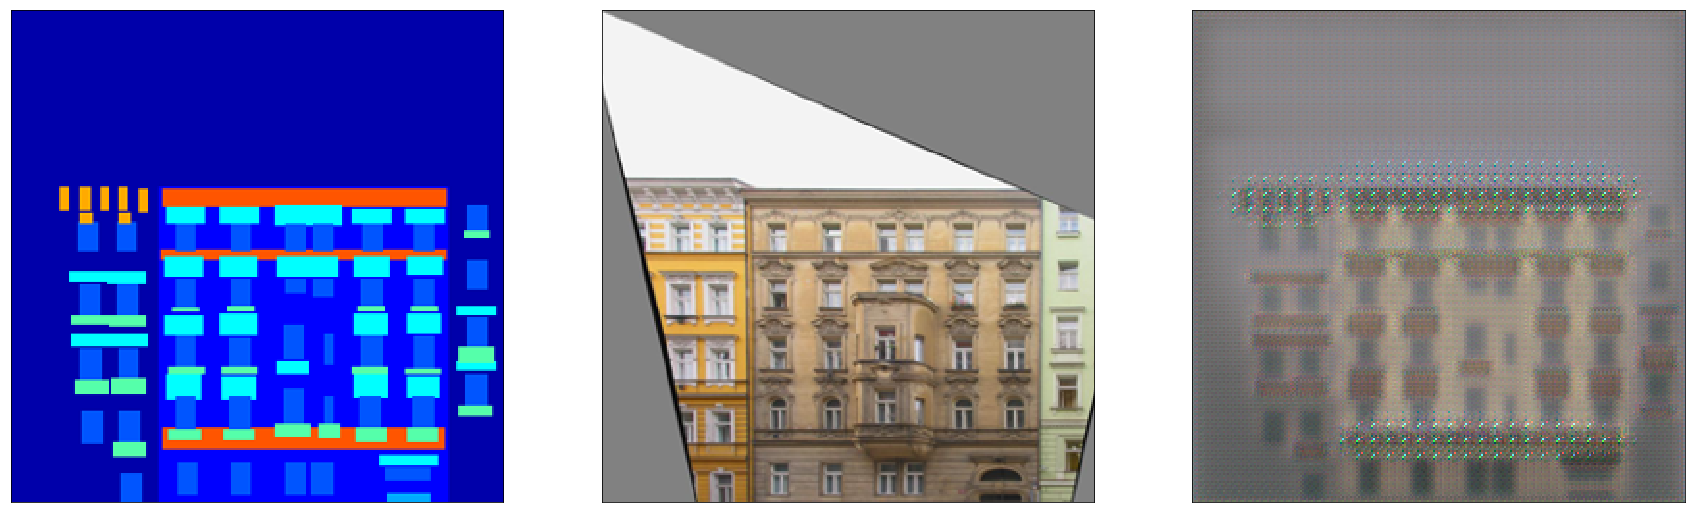

Epoch[1](400/400): Loss_D: 0.2465 Loss_G: 2.9420


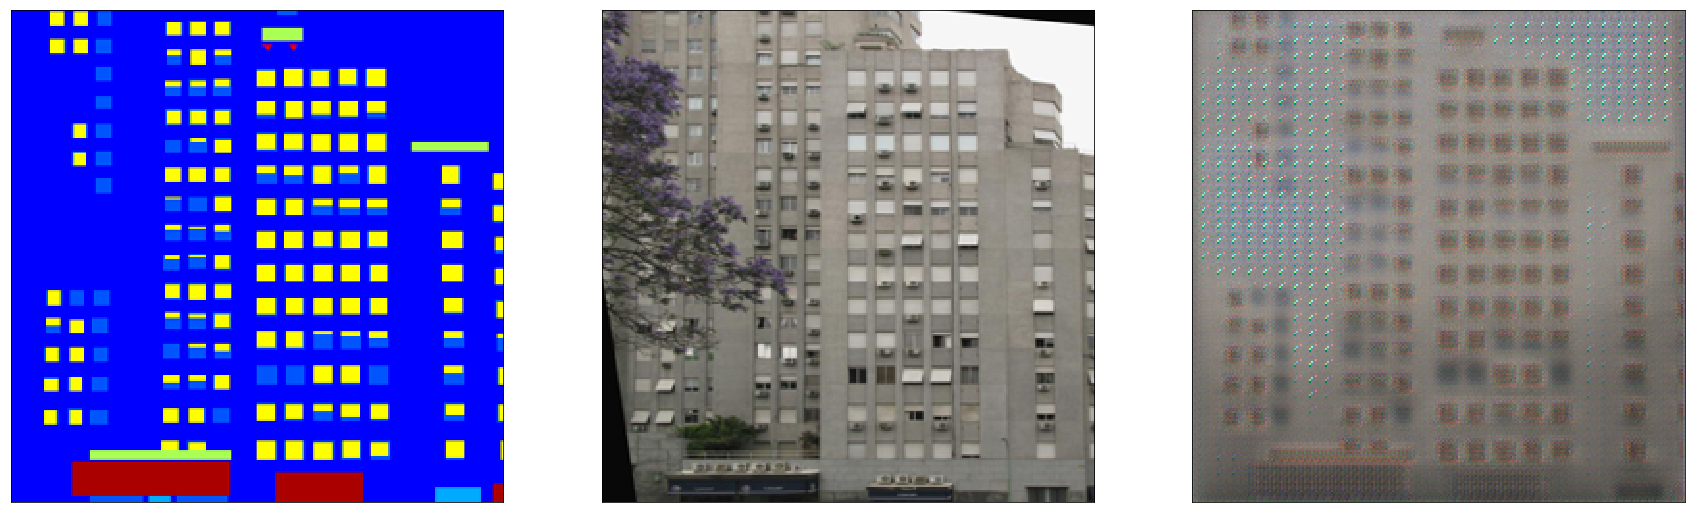

Epoch[2](200/400): Loss_D: 0.2391 Loss_G: 3.7722


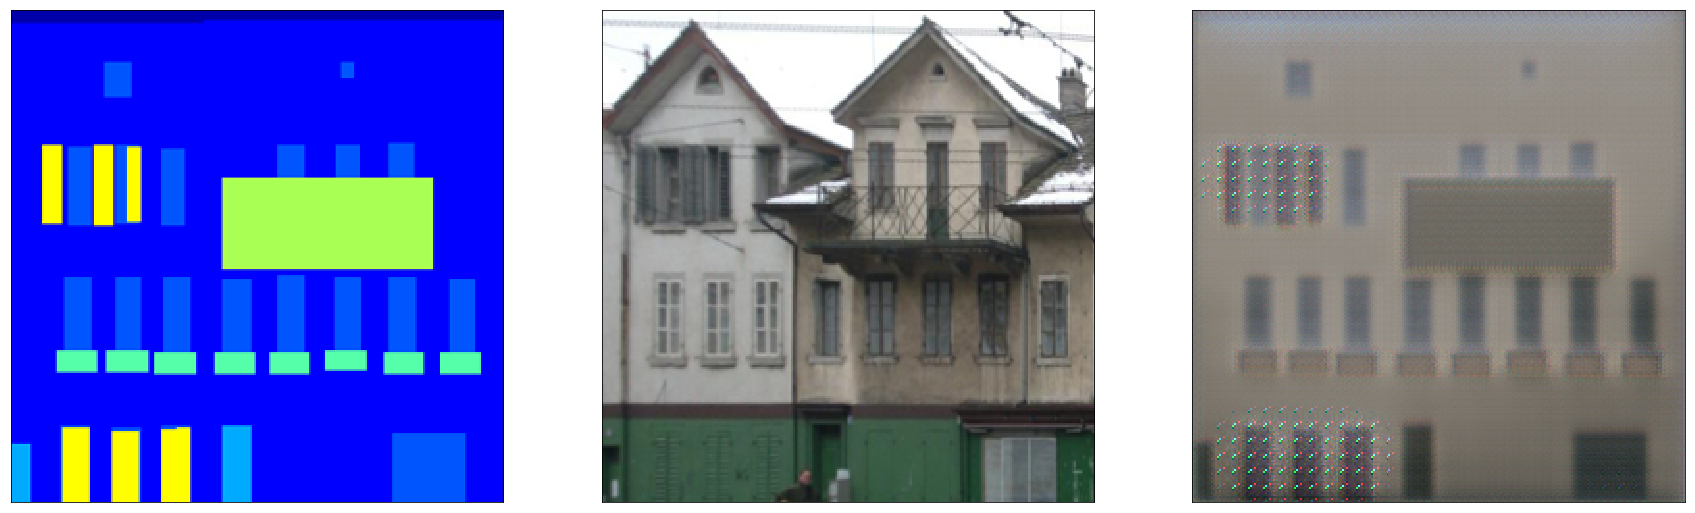

Epoch[2](400/400): Loss_D: 0.2362 Loss_G: 3.8934


Traceback (most recent call last):
  File "/home/sunghyun/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/sunghyun/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/sunghyun/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/sunghyun/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/sunghyun/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/sunghyun/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/sunghyun/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_by

KeyboardInterrupt: 

In [0]:
for epoch in range(1, 200):
    # train
    for iteration, batch in enumerate(training_data_loader, 1):
        # forward
        real_a, real_b = batch[0].to(device), batch[1].to(device)
        fake_b = G(real_a)
        
        real_label = to_var(torch.ones(1))
        fake_label = to_var(torch.zeros(1))

        #============= Train the discriminator =============#

        optimizer_d.zero_grad()
        
        # train with fake
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = D.forward(fake_ab.detach())
        loss_d_fake = criterionMSE(pred_fake, fake_label)

        # train with real
        real_ab = torch.cat((real_a, real_b), 1)
        pred_real = D.forward(real_ab)
        loss_d_real = criterionMSE(pred_real, real_label)
        
        # Combined D loss
        loss_d = (loss_d_fake + loss_d_real) * 0.5

        loss_d.backward()
       
        optimizer_d.step()

        #=============== Train the generator ===============#

        optimizer_g.zero_grad()

        # First, G(A) should fake the discriminator
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = D.forward(fake_ab)
        loss_g_gan = criterionMSE(pred_fake, real_label)

        # Second, G(A) = B
        loss_g_l1 = criterionL1(fake_b, real_b) * 10
        
        loss_g = loss_g_gan + loss_g_l1
        
        loss_g.backward()

        optimizer_g.step()

        
        if iteration % 200 == 0:
            print("Epoch[{}]({}/{}): Loss_D: {:.4f} Loss_G: {:.4f}".format(
            epoch, iteration, len(training_data_loader), loss_d.item(), loss_g.item()))
            show_images(denorm(real_a.squeeze()), denorm(real_b.squeeze()), denorm(fake_b.squeeze()))

## Test

![image.png](attachment:image.png)

In [0]:
avg_psnr = 0
for batch in testing_data_loader:
    input, target = batch[0].to(device), batch[1].to(device)
    output = G(input)
    
    mse = criterionMSE(output, target)
    psnr = 10 * log10(1 / mse.item())
    avg_psnr += psnr
print("Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))

Avg. PSNR: 7.9746 dB


In [0]:
torch.save(G.state_dict(), "./model/pix2pix_generator.pckl")
torch.save(D.state_dict(), "./model/pix2pix_discriminator.pckl")